## Data Preprocessing

In [27]:
# !pip3 install pandas
# !pip3 install scikit-learn

In [28]:
from PIL import Image
import numpy as np
import glob
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

## ViT base

In [29]:
# !pip install vit-pytorch
# !pip3 install seaborn


In [30]:
from __future__ import print_function
from PIL import Image
from vit_pytorch import ViT
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import glob
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import pickle
import collections
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
import numpy as np
import seaborn as sn

In [31]:
# Setting CUDA Device:
torch.cuda.set_device(0)
# CUDA_VISIBLE_DEVICES= [1,2]

In [32]:
# Importing metadata:
# total_df = pd.read_csv('/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/dataset/ham10000/HAM10000_metadata.csv')
file_list_mel = glob.glob(r'/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/BG_remove/Data/REMOVE/MEL/*.png')
file_list_nev = glob.glob(r'/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/BG_remove/Data/REMOVE/NEVS/*.png')

In [33]:
# Generating labels:
y_all = []
file_list2 = []

for name in file_list_mel:    
  y_all.append('mel')
  file_list2.append(name)

for name in file_list_nev:    
  y_all.append('nev')
  file_list2.append(name)
    

In [34]:
y_all.count("mel")
len(file_list2)
file_list = file_list2

In [35]:
# Encodeing lables:
le = preprocessing.LabelEncoder()
y_all1 = le.fit_transform(y_all)

In [36]:
# print(y_all)
print(len(y_all1))

1228


In [37]:
# Applying test train split
X_train, X_temp, y_train, y_temp = train_test_split(file_list, y_all1, random_state=1, stratify=y_all1, test_size=0.201)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=1, stratify=y_temp, test_size=0.5)


In [38]:
print(len(X_test))

124


In [58]:
# Creating Dataset:
data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ]
)

In [59]:
class MyDataset(Dataset):
    def __init__(self, file_list, y_all, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.y_all = y_all


    def __getitem__(self, index1):
        img_path = self.file_list[index1]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = self.y_all[index1]
        return img_transformed, label

    def __len__(self):
      return len(self.file_list)


In [60]:
train_data = MyDataset(X_train, y_train, transform=data_transforms)
valid_data = MyDataset(X_val, y_val, transform=data_transforms)
test_data = MyDataset(X_test, y_test, transform=data_transforms)

# Fixing Dataloader:
train_loader = DataLoader(dataset = train_data, batch_size=32, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=32, shuffle=True)


In [42]:
len(valid_loader)

4

In [61]:
for data, label in train_loader:
    print("........")
    print(data.size())

........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 4, 224, 224])
........
torch.Size([32, 

In [62]:
# Hyperparameters:
num_epochs = 100
# batch_size_list = [32, 64, 128]
batch_size = 32
# lr_list = [3e-5, 2e-4, 1e-3, 5e-6]
lr_list = [0.0001]
# gamma_list = [0.9, 0.7]  # for learning rate scheduler
gamma_list = [0.7]

In [63]:

# Model Specifications
model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(torch.device("cuda"))



In [65]:

#start training
train_loss_list_list = []
val_loss_list_list = []
train_acc_list_list = []
val_acc_list_list = []

for lr in lr_list:
    for gamma in gamma_list:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

        train_loss_list = []
        val_loss_list = []
        train_acc_list = []
        val_acc_list = []
        print("lr:", lr, "    gamma:", gamma)
        for epoch in range(num_epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            for data, label in train_loader:
                data = data.to(torch.device("cuda"))
                label = label.to(torch.device("cuda"))
                output = model(data)
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == label).float().mean()
                epoch_accuracy += accuracy / len(train_loader)
                epoch_loss += loss / len(train_loader)
            with torch.no_grad():
                epoch_val_accuracy = 0
                epoch_val_loss = 0
                for data, label in valid_loader:
                    data = data.to(torch.device("cuda"))
                    label = label.to(torch.device("cuda"))
                    val_output = model(data)
                    val_loss = criterion(val_output, label)
                    acc = (val_output.argmax(dim=1) == label).float().mean()
                    epoch_val_accuracy += acc / len(valid_loader)
                    epoch_val_loss += val_loss / len(valid_loader)
            train_loss_list.append(epoch_loss.detach().cpu().numpy().flatten()[0])
            train_acc_list.append(epoch_accuracy.detach().cpu().numpy().flatten()[0])
            val_loss_list.append(epoch_val_loss.detach().cpu().numpy().flatten()[0])
            val_acc_list.append(epoch_val_accuracy.detach().cpu().numpy().flatten()[0])
            print(
                f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
            )
        val_acc_list_list.append(val_acc_list)
        val_loss_list_list.append(val_loss_list)
        train_acc_list_list.append(train_acc_list)
        train_loss_list_list.append(train_loss_list)


lr: 0.0001     gamma: 0.7


RuntimeError: Given normalized_shape=[3072], expected input with shape [*, 3072], but got input of size[32, 49, 4096]

In [ ]:

torch.save(model.state_dict(), '/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/vit/Base Vit/FinalModelsSimple/ViT_model.pth')
metrices = [train_loss_list, val_loss_list, train_acc_list, val_acc_list]
with open("/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/vit/Base Vit/FinalModelsSimple/ViT_metrices.pk", "wb") as fp:   #Pickling
    pickle.dump(metrices, fp)

# a = []
# for i in range(0, num_epochs):
#     a.append(val_acc_list[i].detach().cpu().numpy().flatten()[0])
# maxi = []
# for i in range(0, 8):
#     maxi.append(max(val_acc_list_list[i]))



In [ ]:
# loading model:
oldP = "/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/vit/Base Vit/FinalModelsSimple/ViT_model.pth"
model.load_state_dict(torch.load(oldP))
model.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elemen

In [ ]:
# Creating Validation predictions and metrics:

pred = []
pred_label = []
i=0
criterion = nn.CrossEntropyLoss()
print(len(X_val))
for i in range(0,len(X_val)):
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0

        for data, label in valid_loader: #! Change: test_loader --> valid_loader           
            if i%100==0:
                print("step: ", i)
            i +=1
            data = data.to(torch.device("cuda"))
            label = label.to(torch.device("cuda"))
            val_output = model(data)
            val_loss = criterion(val_output, label)
            pred.append(list(val_output.argmax(dim=1).detach().cpu().numpy()))
            pred_label.append(list(label.detach().cpu().numpy()))
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

val_pred_flat = [item for sublist in pred for item in sublist]
val_pred_label_flat = [item for sublist in pred_label for item in sublist]

123
step:  0
step:  100
step:  100
step:  100
step:  100


In [ ]:
# len(test_loader)
print(len(test_loader.dataset))

124


In [ ]:
# Creating test set predictions and mertrices:

pred = []
pred_label = []
i=0
criterion = nn.CrossEntropyLoss()
print(len(X_test))
for i in range(0,len(X_test)):    
    # test_data = MyDataset([X_test[i]], [y_test[i]], transform=transforms)
    # test_loader = DataLoader(dataset = test_data, batch_size=1, shuffle=False)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0

        for data, label in test_loader:            
            if i%100==0:
                print("step: ", i)
            i +=1
            data = data.to(torch.device("cuda"))
            label = label.to(torch.device("cuda"))
            val_output = model(data)            
            val_loss = criterion(val_output, label)
            pred.append(list(val_output.argmax(dim=1).detach().cpu().numpy()))
            print(list(val_output.argmax(dim=1).detach().cpu().numpy()))
            pred_label.append(list(label.detach().cpu().numpy()))
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
        
        break

test_pred_flat = [item for sublist in pred for item in sublist]
test_pred_label_flat = [item for sublist in pred_label for item in sublist]

predictions = [val_pred_flat, val_pred_label_flat, test_pred_flat, test_pred_label_flat]
with open("/home/uditha/snap/snapd-desktop-integration/current/Desktop/FYP/vit/Base Vit/FinalModelsSimple/ViT_predictions.pk", "wb") as fp:   #Pickling
    pickle.dump(predictions, fp)

124
step:  0
[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]


In [ ]:
test_pred_flat_1 = [len(sublist) for sublist in pred ]



ViT MODEL:  
              precision    recall  f1-score   support

           0     0.6613    0.7455    0.7009        55
           1     0.7742    0.6957    0.7328        69

    accuracy                         0.7177       124
   macro avg     0.7177    0.7206    0.7168       124
weighted avg     0.7241    0.7177    0.7186       124

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]


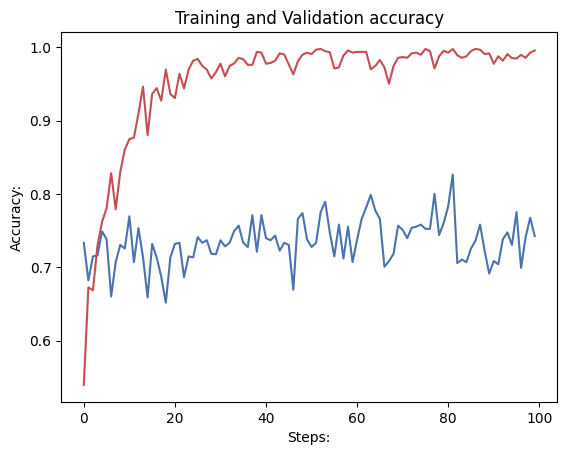

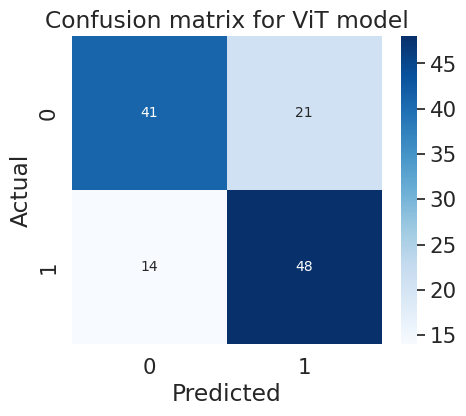

In [ ]:

# Plotting training and val accuracy with training steps:
train_acc_list = metrices[2]
val_acc_list = metrices[3]

plt.plot(range(0,len(val_acc_list)), val_acc_list, color='b', label='Validation accuracy')
plt.plot(range(0,len(train_acc_list)), train_acc_list, color='r', label='Training accuracy')
plt.title("Training and Validation accuracy")
plt.xlabel("Steps:")
plt.ylabel("Accuracy:")

# Precsion and recall:
# with open('./final_models_simple/ViT_predictions.pk', 'rb') as f:
#     predictions = pickle.load(f)

val_pred_flat = predictions[0]
val_pred_label_flat = predictions[1]
test_pred_flat = predictions[2]
test_pred_label_flat = predictions[3]
print("\n\nViT MODEL:  ")
print(classification_report(test_pred_flat, test_pred_label_flat,digits=4))
# Confusion Matrix:
y_true = test_pred_label_flat
y_pred = test_pred_flat
print(y_true)
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size":10}, fmt='d')# font size
plt.title("Confusion matrix for ViT model")
plt.show()

In [ ]:
data

array([[41, 21],
       [14, 48]])

In [ ]:
len(predictions[1])

15129